In [24]:
import itertools
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as model_selection
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Load dataset and define transformation functions

#### load initial dataset

In [25]:
df = pd.read_csv("train_set_data.csv")

#### Check if the dataset is unbalanced

[Text(0.5, 1.0, 'Number of molecules per tag')]

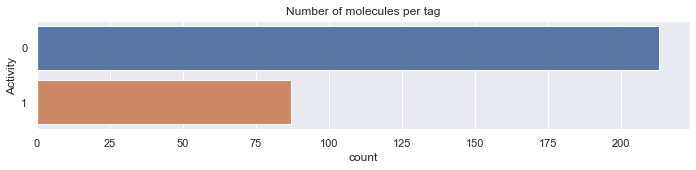

In [26]:
sns.set(rc={"figure.figsize": (11.7, 2)})
sns.countplot(data=df, y="Activity").set(title="Number of molecules per tag")

#### Define a smiles encoder

In [27]:
def VectFromSmiles(smiles: str, radius: int = 2, nBits: int = 1024):
    """Encodes a smiles into a vector of size nBits
    Args:
        - smiles: simplified molecular-input line-entry system
        - radius: integer between 1 and 6
        - nBits: vector size (possible values : 512, 1024, 2048, 4096)
    """
    mol = Chem.MolFromSmiles(smiles.strip())
    if mol:
        return list(
            rdMolDescriptors.GetMorganFingerprintAsBitVect(
                mol, radius=radius, nBits=nBits
            )
        )
    raise ValueError(f"{smiles} is not a valid SMILES representation")

# Classifier selection
Cross validation in order to determine the optimal hyperparamters for each model. Technically, I used a GridSearchCV-like method in order to include radius and nBits parameters

#### Regularized logistic regression Classifier

In [28]:
indices_train, indices_test = model_selection.train_test_split(
    range(len(df)), test_size=0.2, random_state=200
)

scores_LogReg = []
hyperparameters_LogReg = []
for radius, nBits, C, penalty in tqdm(
    itertools.product(
        [2, 3, 4, 5, 6],
        [512, 1024, 2048],
        [int(x) for x in np.linspace(0, 1, num=100)],
        ["l1", "l2"],
    )
):
    X = pd.DataFrame(
        df["SMILES"]
        .apply(lambda x: VectFromSmiles(x, radius=radius, nBits=nBits))
        .tolist()
    )
    y = df["Activity"]
    X_train = X.loc[indices_train]
    y_train = y.loc[indices_train]
    cv_score = np.mean(
        cross_val_score(
            LogisticRegression(C=C, penalty=penalty),
            X_train,
            y_train,
            cv=4,
            scoring="roc_auc",
        )
    )
    scores_LogReg.append(cv_score)
    hyperparameters_LogReg.append(
        {"radius": radius, "nBits": nBits, "C": C, "penalty": penalty}
    )

best_score_LogReg = scores_LogReg[np.nanargmax(scores_LogReg)]
best_params_LogReg = hyperparameters_LogReg[np.nanargmax(scores_LogReg)]

print(f"Best score of LogReg: {best_score_LogReg}")
print(f"Best parameters of LogReg: {best_params_LogReg}")

3000it [26:42,  1.87it/s]

Best score of LogReg: 0.812306382501321
Best parameters of LogReg: {'radius': 2, 'nBits': 2048, 'C': 1, 'penalty': 'l2'}


#### Random Forest Classifier

In [29]:
scores_RFC = []
hyperparameters_RFC = []
for radius, nBits, n_estimators, max_depth, min_samples_split, min_samples_leaf in tqdm(
    itertools.product(
        [2, 3, 4, 5, 6],
        [512, 1024, 2048],
        [int(x) for x in np.linspace(10, 100, num=5)],
        [int(x) for x in np.linspace(3, 20, num=8)],
        [2, 5, 10],
        [int(x) for x in np.linspace(2, 10, num=5)],
    )
):
    X = pd.DataFrame(
        df["SMILES"]
        .apply(lambda x: VectFromSmiles(x, radius=radius, nBits=nBits))
        .tolist()
    )
    y = df["Activity"]
    X_train = X.loc[indices_train]
    y_train = y.loc[indices_train]
    cv_score = np.mean(
        cross_val_score(
            RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
            ),
            X_train,
            y_train,
            cv=4,
            scoring="roc_auc",
        )
    )
    scores_RFC.append(cv_score)
    hyperparameters_RFC.append(
        {
            "radius": radius,
            "nBits": nBits,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
        }
    )

best_score_RFC = scores_RFC[np.nanargmax(scores_RFC)]
best_params_RFC = hyperparameters_RFC[np.nanargmax(scores_RFC)]

print(f"Best score of RFC: {best_score_RFC}")
print(f"Best parameters of RFC: {best_params_RFC}")

9000it [2:14:45,  1.11it/s]

Best score of RFC: 0.8293411033664111
Best parameters of RFC: {'radius': 4, 'nBits': 512, 'n_estimators': 55, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2}


#### Random Forest Classifier (score : 0.83) is better than Logistic Regression (score : 0.81)

In [30]:
best_radius = best_params_RFC["radius"]
best_nBits = best_params_RFC["nBits"]
best_n_estimators = best_params_RFC["n_estimators"]
best_max_depth = best_params_RFC["max_depth"]
best_min_samples_split = best_params_RFC["min_samples_split"]
best_min_samples_leaf = best_params_RFC["min_samples_leaf"]

# Optimal model training
In order to save the optimal parameters (as a .pkl) and to use the model in the API

In [31]:
X = pd.DataFrame(
    df["SMILES"]
    .apply(lambda x: VectFromSmiles(x, radius=best_radius, nBits=best_nBits))
    .tolist()
)
y = df["Activity"]
X_train = X.loc[indices_train]
y_train = y.loc[indices_train]
X_test = X.loc[indices_test]
y_test = y.loc[indices_test]

In [32]:
Model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
)
Model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=55)

In [33]:
roc_auc_score(Model.predict(X_test), y_test)

0.7439353099730459

In [34]:
Model.fit(X, y)

RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=55)

In [35]:
pickle.dump(Model, open("model.pkl", "wb"))